# Training progress analysis of Learning Brain data

The code below allows to visualize and analize data from 6-week working memory training study. Participants performed 18 sessions of dual n-back training (Jaeggi et al., 2018). Each session consisted of 20 runs of the task. The level of *n* increased with at least 80% correct trials in previous run.


Karolina Finc | Centre for Modern Interdisciplinary Technologies

**Last edited**: 09.05.2017


Preparing data
--------------------------------------

In [3]:
# Loading packages
library(tidyverse)
library(broom)

# Setting working directory
setwd("~/Dropbox/GitHub/LearningBrain_analyses")

# Loading data
training <- read.csv("data/LB_training_progress.csv")

# Checking data
glimpse(training) 


Observations: 414
Variables: 22
$ sub     <fct> LB005, LB005, LB005, LB005, LB005, LB005, LB005, LB005, LB0...
$ session <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ X1      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ X2      <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...
$ X3      <int> 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2,...
$ X4      <int> 2, 3, 3, 2, 3, 2, 3, 3, 4, 3, 3, 4, 4, 3, 4, 4, 3, 3, 2, 2,...
$ X5      <int> 2, 2, 3, 2, 3, 3, 2, 3, 3, 3, 3, 4, 4, 3, 3, 4, 3, 3, 3, 2,...
$ X6      <int> 2, 2, 3, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 3, 3, 4, 3, 3, 2, 2,...
$ X7      <int> 2, 2, 2, 4, 2, 4, 2, 2, 4, 3, 3, 5, 5, 2, 3, 4, 4, 4, 2, 2,...
$ X8      <int> 2, 3, 1, 3, 2, 4, 2, 3, 4, 2, 3, 5, 6, 3, 4, 4, 5, 4, 3, 3,...
$ X9      <int> 1, 2, 2, 2, 3, 3, 2, 4, 4, 3, 4, 5, 6, 4, 4, 4, 5, 3, 2, 3,...
$ X10     <int> 2, 3, 3, 2, 3, 4, 3, 4, 3, 3, 4, 5, 5, 4, 4, 4, 5, 3, 2, 4,...
$ X11     <int> 2, 2

In [4]:
?gather

In [15]:
# Formatting subjects' names according to BIDS
training_tidy <- training %>% gather(key = "trial", value = "n_level", -sub, -session)

training_tidy$sub <- as.factor(gsub("LB0", "sub-", training_tidy$sub))
training_tidy$trial <- as.factor(gsub("X", "", training_tidy$trial))

# Checking data
glimpse(training_tidy) 

Observations: 8,280
Variables: 4
$ sub     <fct> sub-05, sub-05, sub-05, sub-05, sub-05, sub-05, sub-05, sub...
$ session <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ trial   <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ n_level <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...


Calculating summary measures
--------------------------------------

In [38]:
training_tidy_summary <- training_tidy %>% 
    group_by(sub, session) %>%
    summarize(nback_mean = mean(n_level), nback_max = max(n_level))


head(training_tidy_summary)

sub,session,nback_mean,nback_max
sub-05,1,2.05,3
sub-05,2,2.30,3
sub-05,3,2.55,3
sub-05,4,2.50,4
sub-05,5,2.80,4
sub-05,6,3.10,4


Mean n-back values
--------------------------------------

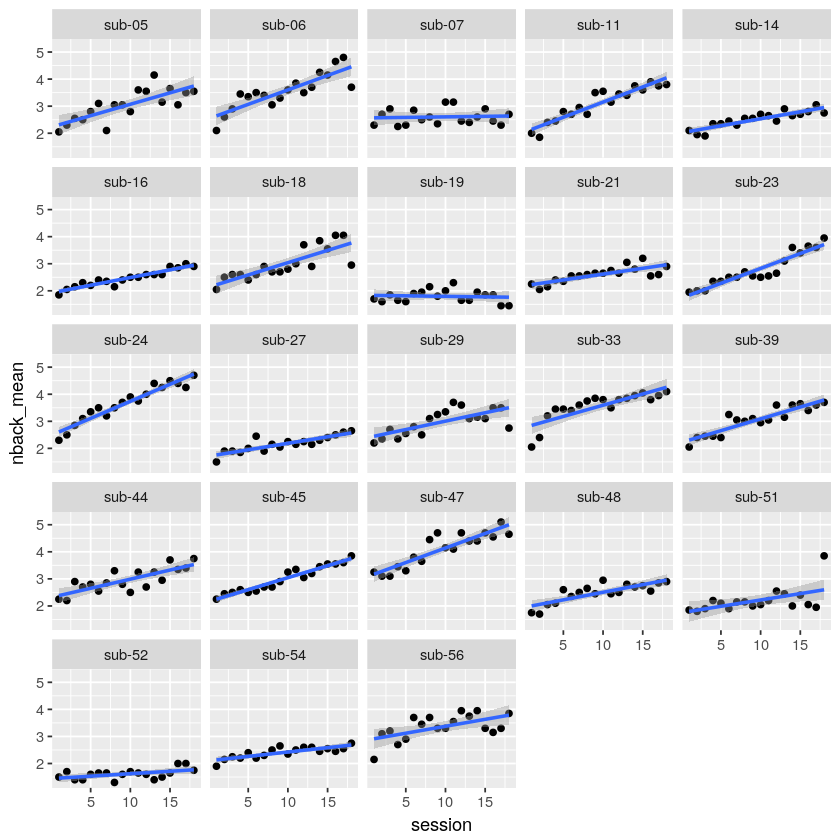

In [24]:
# Plotting data for individual subject (mean n-back level)

ggplot(training_tidy_summary, aes(x = session, y = nback_mean)) + 
    geom_point() + 
    geom_smooth(method = "lm") + 
    facet_wrap( ~ sub)


session,mean_nback_group,max_nback_group
1,2.058696,2.913043
2,2.232609,3.173913
3,2.426087,3.391304
4,2.471739,3.347826
5,2.541304,3.521739
6,2.723913,3.826087


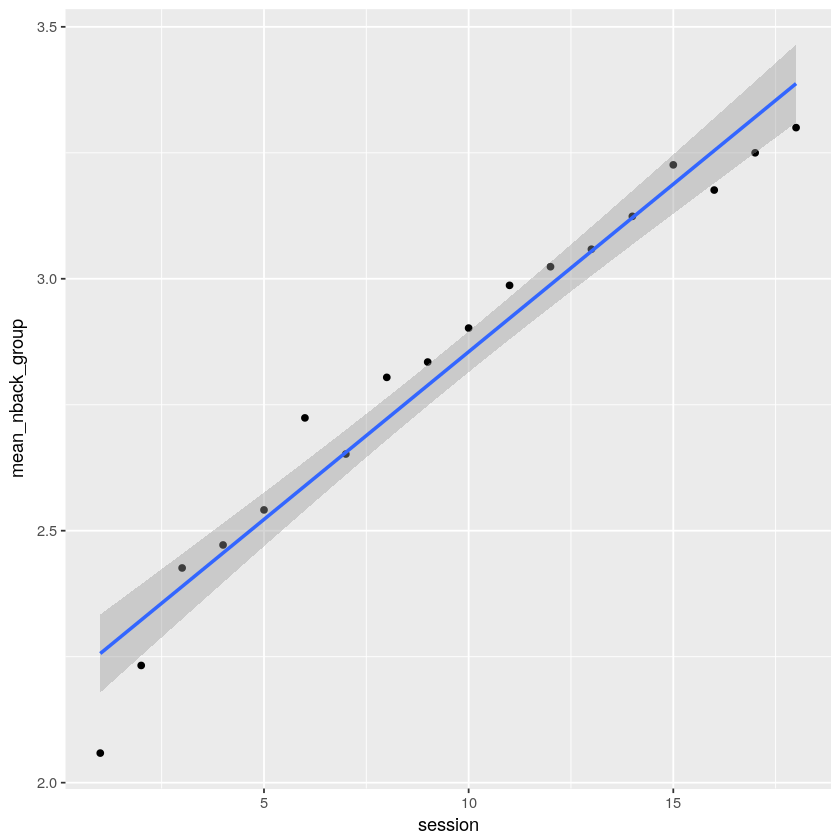

In [35]:
# Plotting data for all subjects

# Summarizing data by session
training_group <- training_tidy_summary %>% 
    group_by(session) %>% 
    summarize(mean_nback_group = mean(nback_mean), max_nback_group = mean(nback_max))

head(training_group)

# Plotting mean of all subjects performance
ggplot(training_group, aes(x = session, y = mean_nback_group)) + 
    geom_point() + 
    geom_smooth(method = "lm")

Observations: 23
Variables: 2
$ sub                 <fct> sub-05, sub-06, sub-07, sub-11, sub-14, sub-16,...
$ nback_mean_estimate <dbl> 0.084416925, 0.106656347, 0.003973168, 0.112074...


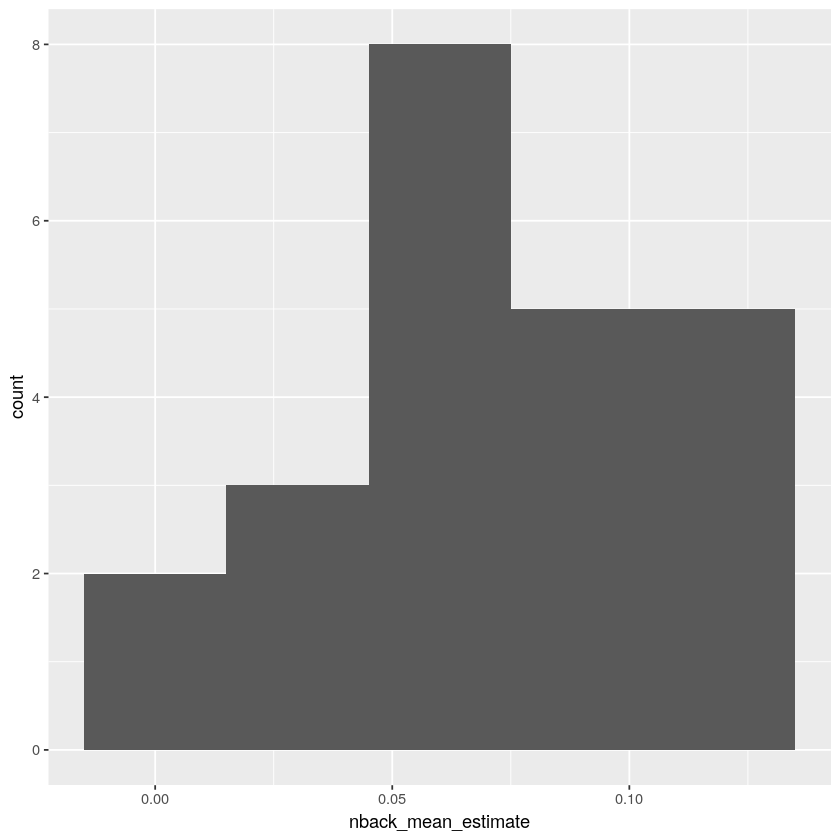

In [27]:
# Nesting to obtain dataframe with linear regression results for each subject
training_lm_mean_full <- training_tidy_summary %>% 
    nest(-sub) %>%
    mutate(model = map(data, ~ lm(nback_mean ~ session, data = .))) %>% 
    mutate(tidied = map(model, tidy)) %>% 
    unnest(tidied)

# Selecting rows with linear regression estimates
training_lm_mean_slope <- training_lm_mean_full %>% 
    filter(term == "session") %>% 
    rename(nback_mean_estimate = estimate) %>%
    select(sub, nback_mean_estimate)

# Checking
glimpse(training_lm_mean_slope)

# Plotting histagram of estimates
ggplot(training_lm_mean_slope, aes(nback_mean_estimate)) + geom_histogram(binwidth = 0.03)



Maximum n-back values
--------------------------------------

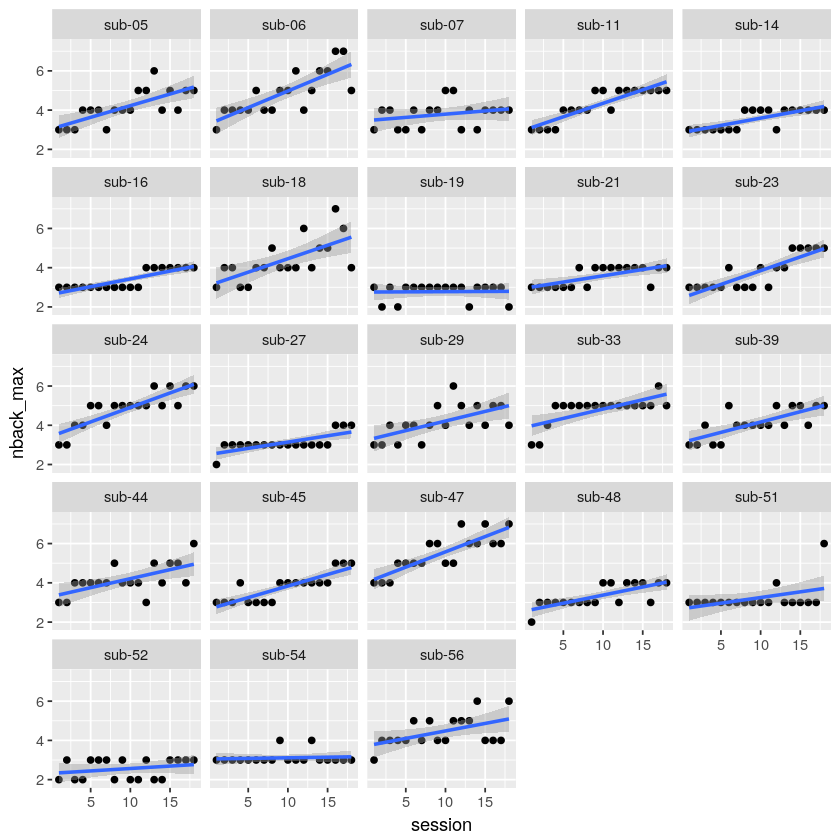

In [34]:
# Plotting data for individual subject (mean n-back level)

ggplot(training_tidy_summary, aes(x = session, y = nback_max)) + 
    geom_point() + 
    geom_smooth(method = "lm") + 
    facet_wrap( ~ sub)

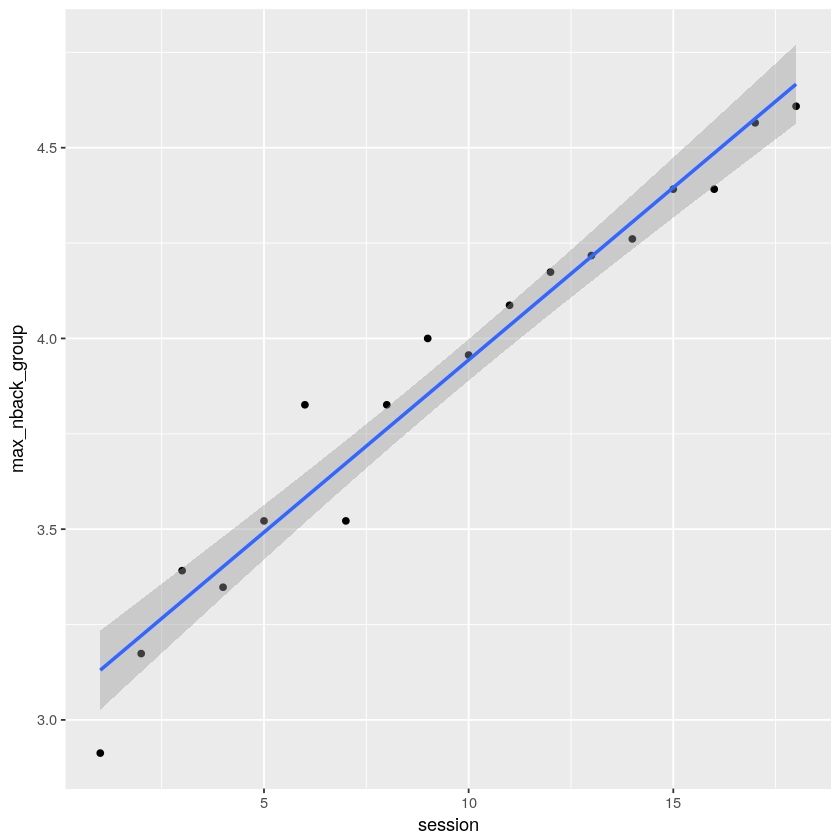

In [36]:
# Plotting data for all subjects


# Plotting mean of all subjects performance
ggplot(training_group, aes(x = session, y = max_nback_group)) + 
    geom_point() + 
    geom_smooth(method = "lm")

sub,nback_max_estimate
sub-05,0.118679051
sub-06,0.169246646
sub-07,0.033023736
sub-11,0.137254902
sub-14,0.074303406
sub-16,0.079463364
sub-18,0.137254902
sub-19,0.002063983
sub-21,0.063983488
sub-23,0.140350877


Observations: 23
Variables: 2
$ sub                <fct> sub-05, sub-06, sub-07, sub-11, sub-14, sub-16, ...
$ nback_max_estimate <dbl> 0.118679051, 0.169246646, 0.033023736, 0.1372549...


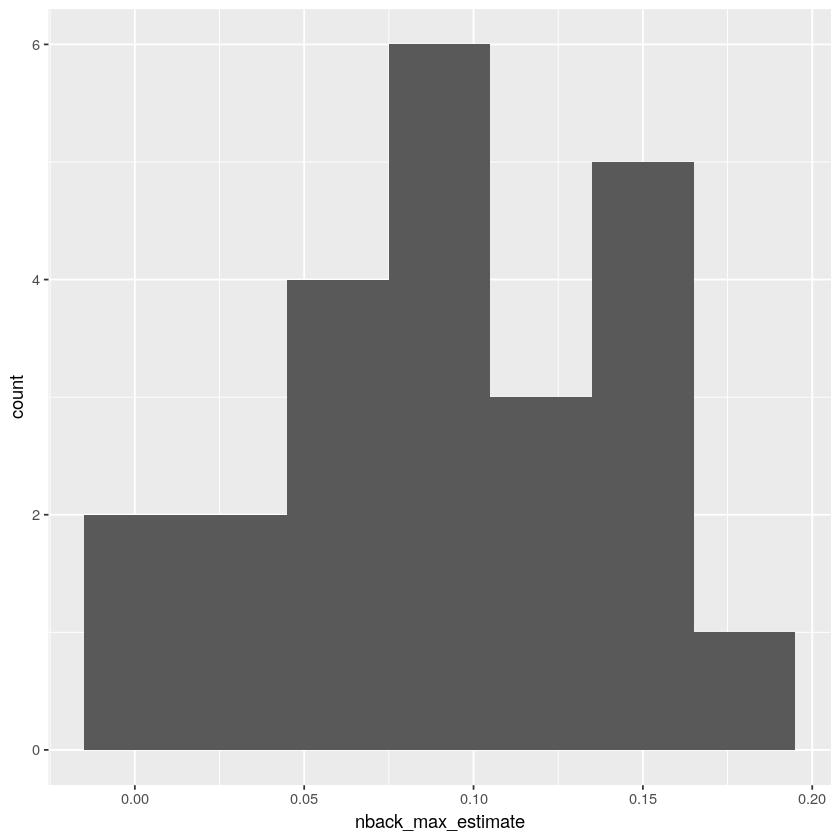

In [39]:

# Nesting to obtain dataframe with linear regression results for each subject
training_lm_max_full <- training_tidy_summary %>% 
    nest(-sub) %>%
    mutate(model = map(data, ~ lm(nback_max ~ session, data = .))) %>% 
    mutate(tidied = map(model, tidy)) %>% 
    unnest(tidied)


# Selecting rows with linear regression estimates
training_lm_max_slope <- training_lm_max_full %>% 
    filter(term == "session") %>% 
    rename(nback_max_estimate = estimate) %>%
    select(sub, nback_max_estimate)

training_lm_max_slope


# Checking
glimpse(training_lm_max_slope)


# Plotting histagram of estimates
ggplot(training_lm_max_slope, aes(nback_max_estimate)) + geom_histogram(binwidth = 0.03)



Additional performance summaries
--------------------------------------

In [40]:
# Filtering dataset to obtain baseline n-level (mean n-back level at first training session)
training_baseline <- training_tidy_summary %>% filter(session == 1) %>% rename(nback_baseline = nback_mean) %>% 
    select(sub, nback_baseline) 

# Filtering dataset to obtain maximum n-level at the whole training period
training_max <- training_tidy_summary %>% group_by(sub) %>% summarize(nback_max_level = max(nback_max))


Joining and saving data
--------------------------------------

In [41]:
# Joining all together
training_summary <- left_join(training_lm_mean_slope, training_lm_max_slope) %>% 
    left_join(training_baseline) %>% 
    left_join(training_max)

head(training_summary)

# Writing training summary to a table
write.csv(training_summary,  file = "data/LB_training_summary.csv", row.names = FALSE)



Joining, by = "sub"
Joining, by = "sub"
Joining, by = "sub"


sub,nback_mean_estimate,nback_max_estimate,nback_baseline,nback_max_level
sub-05,0.084416925,0.11867905,2.05,6
sub-06,0.106656347,0.16924665,2.10,7
sub-07,0.003973168,0.03302374,2.30,5
sub-11,0.112074303,0.13725490,2.00,5
sub-14,0.051754386,0.07430341,2.10,4
sub-16,0.056965944,0.07946336,1.85,4


Example of correlation analysis (teaching material)
----------------------------------------------------------------------------


	Pearson's product-moment correlation

data:  training_summary$nback_mean_estimate and training_summary$nback_max_level
t = 3.9479, df = 21, p-value = 0.0007359
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3290041 0.8391323
sample estimates:
      cor 
0.6526908 


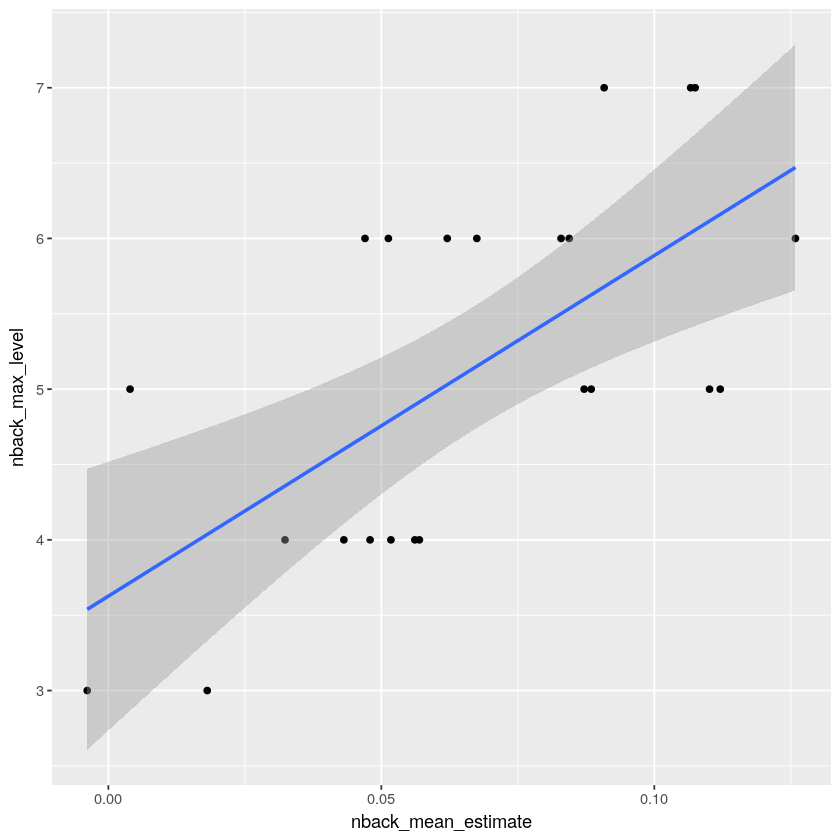

In [46]:
# making scatterplot

ggplot(training_summary, aes(x = nback_mean_estimate, y = nback_max_level)) + 
    geom_point() + 
    geom_smooth(method = "lm")

# running Pearson's correlation test
cor.test(training_summary$nback_mean_estimate, training_summary$nback_max_level)